In [8]:
import tensorflow as tf 
from Vnet_multiclass import CreateVnet
from Unet_modified import CreateUnetModified
import os
from sklearn.model_selection import train_test_split
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.transform as skTrans
import math
from supporters import explore_3D_array_with_viewpoint

In [9]:
rootDirPath = "..\\mmwhs\\ct_train"
pathList = os.listdir(rootDirPath)

In [4]:
# a = np.array(nib.load("E:\isef-vascular\VascuIAR\DeepLearning\mmwhs\ct_train\ct_train_1001_image.nii.gz").get_fdata())

# with open(".\\temp.txt", "w") as f: 
#     f.write("First view\n")
#     for i in range(a.shape[0]): 
#         u = np.unique(a[i, :, :])
#         f.write(f"Slice {i} has {len(u)} unique values which are: {u}\n")
#     del i 

#     f.write("\nSecond view\n")
#     for i in range(a.shape[1]): 
#         u = np.unique(a[:, i, :])
#         f.write(f"Slice {i} has {len(u)} unique values which are: {u}\n")
#     del i 

#     f.write("\nThird view\n")
#     for i in range(a.shape[2]): 
#         u = np.unique(a[:, :, i])
#         f.write(f"Slice {i} has {len(u)} unique values which are: {u}\n")
#     del i 

### EACH VIEW HAS DIFFERENT UNIQUE VALUES => INCONSISTENT WHEN TRYING TO REMOVE SLICES WITHOUT HEART + BY REMOVING SLICES WITHOUT HEART, IT WEAKENS THE MODEL'S ABILITY TO DIFFRENTIATE STRUCTUERS LIKE BONES / AIR IN SLICES CONTAINING HEART. 

# => 2 SOLUTIONS: 
#   1) Fill labels with zeros and real data with bone structures to make everything the same size
#   2) Crop all slices without heart to make it the same size  

# Cropping and Adding all add biases and unbalance to the dataset, except cropping is much harder to do homologously => Fill and offset bias 

# BOTH SOLUTIONS DOES NOT WORK WHEN TRAINING MODEL FOR IT ADDS TO MUCH UNNECESSARY DATA OR BECOMES TOO INCONSISTENT. 

# => INTERPOLATION FOR IMAGE DIMENSION REDUCTION

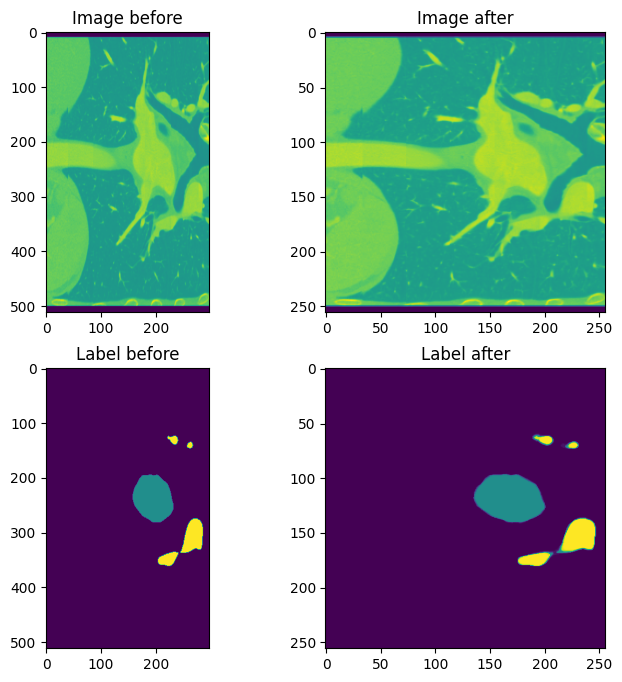

In [10]:
# VISUALIZE DIMENSION INTERPOLATION FOR IMAGE SIZE REDUCTION

im = nib.load(os.path.join(
    rootDirPath, "ct_train_1019_image.nii.gz")).get_fdata()
result1 = np.array(skTrans.resize(im, (256, 256, 256), order=1,
                   preserve_range=True, anti_aliasing=False), dtype="float16")
label = nib.load(os.path.join(
    rootDirPath, "ct_train_1019_label.nii.gz")).get_fdata()
result2 = np.array(skTrans.resize(label, (256, 256, 256),
                   order=1, preserve_range=True), dtype="float16")
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# TO CALCULATE WHERE y = 90 will end up in the resized array, we take int((90 * 128) / 512) 

axes[0][0].set_title("Image before")
axes[0][0].imshow(im[:, 180, :])
axes[0][1].set_title("Image after")
axes[0][1].imshow(result1[:, 90, :])

axes[1][0].set_title("Label before")
axes[1][0].imshow(label[:, 180, :])
axes[1][1].set_title("Label after")
axes[1][1].imshow(result2[:, 90, :])

In [11]:
explore_3D_array_with_viewpoint(result1, viewpoint=3)

interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

In [30]:
def OneHotEncode(original, x_, y_, z_, num_classes=8):
    encodeList = {
        0: 0,
        500: 1,
        600: 2,
        420: 3,
        550: 4,
        205: 5,
        820: 6,
        850: 7,
    }

    x, y, z = original.shape

    labelEncode = np.empty((x_, y_, z_, num_classes), dtype="float16")
    for i_ in range(x_):
        for j_ in range(y_):
            for k_ in range(z_):
                i = math.floor((i_ * x) / x_)
                j = math.floor((j_ * y) / y_)
                k = math.floor((k_ * z) / z_)

                i = max(0, min(i, x - 1))
                j = max(0, min(j, y - 1))
                k = max(0, min(k, k - 1))

                value = original[i][j][k]

                encodeIndex = encodeList[value]

                for n in range(8):
                    labelEncode[i_][j_][k_][n] = 0

                labelEncode[i_][j_][k_][encodeIndex] = 1

    return labelEncode


In [16]:
# CREATE ENCODE LABEL TO REDUCE TRAINING TIME 
def GenerateEncodeData(rootDirPath, pathList, x_, y_, z_): 
    newDirPath = "..\\mmwhs\\ct_label_encode\\"
    ordering = 0
    def GetType(fullPath): 
        return fullPath.split("_")[-1].split(".")[0] == "label"
    
    for path in pathList: 
        fullPath = os.path.join(rootDirPath, path)
        if GetType(fullPath): 
            original = np.array(nib.load(fullPath).get_fdata(), dtype="float16")
            labelEncode = OneHotEncode(original, x_, y_, z_)
            print(labelEncode.shape)
            np.save(os.path.join(newDirPath, f"encode_{ordering}"), labelEncode)
            ordering += 1

GenerateEncodeData(rootDirPath, pathList, 256, 256, 256)

(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)
(256, 256, 256, 8)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(256, 256, 256) (256, 256, 256)
[  0 600]


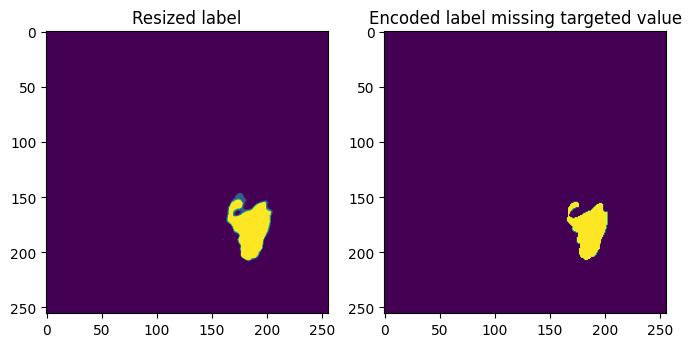

In [32]:
# Validate encode accuracy

def MakeDisappear(targetValue, resizedLabel, labelEncode, targetSlice):
  def MapArgmax(x):
      encodeList = {
          0: 0,
          1: 500,
          2: 600,
          3: 420,
          4: 550,
          5: 205,
          6: 820,
          7: 850,
      }
      return encodeList.get(x, None)
  
  a = labelEncode.copy()
  a = a.argmax(axis=3)
  a[a == targetValue] = 0
  a = np.vectorize(MapArgmax)(a)
  print(a)

  print(resizedLabel.shape, a.shape)
  fig, axes = plt.subplots(1, 2, figsize=(8, 8))
  axes[0].set_title("Resized label")
  axes[0].imshow(resizedLabel[:, :, targetSlice])

  axes[1].set_title("Encoded label missing targeted value")
  axes[1].imshow(a[:, :, targetSlice])

  print(np.unique(a[:, :, targetSlice]))

label = nib.load(os.path.join(rootDirPath, "ct_train_1001_label.nii.gz")).get_fdata()
resizedLabel = np.array(skTrans.resize(label, (256, 256, 256), order=1, preserve_range=True, anti_aliasing=False), dtype="float16")
labelEncode = OneHotEncode(label, 256, 256, 256)

del label

MakeDisappear(2, resizedLabel, labelEncode, 60)

In [ ]:
# Validate encode accuracy
label = nib.load(os.path.join(
    rootDirPath, "ct_train_1001_label.nii.gz")).get_fdata()
result2 = np.array(skTrans.resize(label, (256, 256, 256), order=1,
                   preserve_range=True, anti_aliasing=False), dtype="float16")
labelEncode = OneHotEncode(label, 256, 256, 256)

# fig, axes = plt.subplots(1, 1, figsize=(8, 8))
# axes[0].set_title("Resized label")
# axes[0].plot(label[:, :, 90])

labelEncode = labelEncode.argmax(axis=3, keepdims=True)
print(labelEncode.shape)

In [ ]:
def GenerateData(start, stop, pathList):
  # target is 368 to allow Vnet to compress and decompress
  X = []
  Y = []
  for i in range(start, stop, 2):
      imagePath = os.path.join(rootDirPath, pathList[i])
      labelPath = os.path.join(rootDirPath, pathList[i + 1])

      image = np.array(nib.load(imagePath).get_fdata(), dtype="float16")
      label = np.array(nib.load(labelPath).get_fdata(), dtype="int8")

      image = skTrans.resize(image, (128, 128, 256), order=1, preserve_range=True)


      label = OneHotEncode(label, 128, 128, 256)

      image = np.expand_dims(image, -1)


      print(f"Image shape: {image.shape} || Path: {imagePath}")
      print(f"Label shape : {label.shape} || Path: {labelPath}")

      X.append(image)
      Y.append(label)

  X = np.array(X)
  Y = np.array(Y)

  del image
  del label
  del imagePath
  del labelPath

  return X, Y


def TrainingLoop(model):
  for i in range(0, 30, 2):
    X, Y = GenerateData(i, i + 2, pathList)
    model.fit(X, Y, epochs=1, verbose=1)
    del X
    del Y


In [ ]:
unet = CreateUnetModified(8, 256, 256, 256)

In [ ]:
TrainingLoop(unet)

In [ ]:
def ValidateEncode(original, x_, y_, z_, num_classes=1): 
    encodeList = {
        0: 0, 
        500: 1, 
        600: 2, 
        420: 3, 
        550: 4, 
        205: 5, 
        820: 6, 
        850: 7, 
    }

    x, y, z = original.shape

    labelEncode = np.empty((x_, y_, z_, num_classes), dtype="float16")
    for i_ in range(x_): 
        for j_ in range(y_): 
            for k_ in range(z_): 
                i = math.floor( (i_ * x) / x_)
                j = math.floor( (j_ * y) / y_)
                k = math.floor( (k_ * z) / z_)

                i = max(0, min(i, x - 1))
                j = max(0, min(j, y - 1))
                k = max(0, min(k, k - 1))

                value = original[i][j][k]

                labelEncode[i_][j_][k_][0] = value

    return labelEncode


def GenerateValidateData(start, stop, pathList):
  # target is 368 to allow Vnet to compress and decompress
  X = []
  Y = []
  for i in range(start, stop, 2):
      imagePath = os.path.join(rootDirPath, pathList[i])
      labelPath = os.path.join(rootDirPath, pathList[i + 1])

      image = np.array(nib.load(imagePath).get_fdata(), dtype="float16")
      label = np.array(nib.load(labelPath).get_fdata(), dtype="int8")

      image = skTrans.resize(image, (128, 128, 256), order=1, preserve_range=True)


      label = ValidateEncode(label, 128, 128, 256)
      print(label.shape)
      image = np.expand_dims(image, -1)


      print(f"Image shape: {image.shape} || Path: {imagePath}")
      print(f"Label shape : {label.shape} || Path: {labelPath}")

      X.append(image)
      Y.append(label)

  X = np.array(X)
  Y = np.array(Y)

  del image
  del label
  del imagePath
  del labelPath

  return X, Y

  

def ValidateLoop(model): 
  for i in range(30, 40, 2):
    X, Y = GenerateValidateData(i, i + 2, pathList)
    print(model.evaluate(X, Y))
    del X
    del Y
    break 


In [ ]:
ValidateLoop(unet)